Data Overview:
Dataset Shape: (100, 12)

First 5 rows:
  Area ID City Name District Name  Latitude  Longitude  Zero-dose Count  \
0   MH001      Pune          Pune   18.5204    73.8567               35   
1   MH002    Mumbai        Mumbai   19.0760    72.8777               50   
2   MH003    Nashik        Nashik   19.9975    73.7898               28   
3   MH004   Solapur       Solapur   17.6599    75.9064               40   
4   MH005    Satara        Satara   17.6805    74.0183               22   

   Income  Travel Time  Literacy Rate  Dose_Density  Accessibility_Score  \
0   25000           20           89.6      1.400000             4.480000   
1   22000           35           91.2      2.272727             2.605714   
2   18000           25           87.1      1.555556             3.484000   
3   16000           30           82.5      2.500000             2.750000   
4   14000           18           85.3      1.571429             4.738889   

   Priority_Score  
0           23.12

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

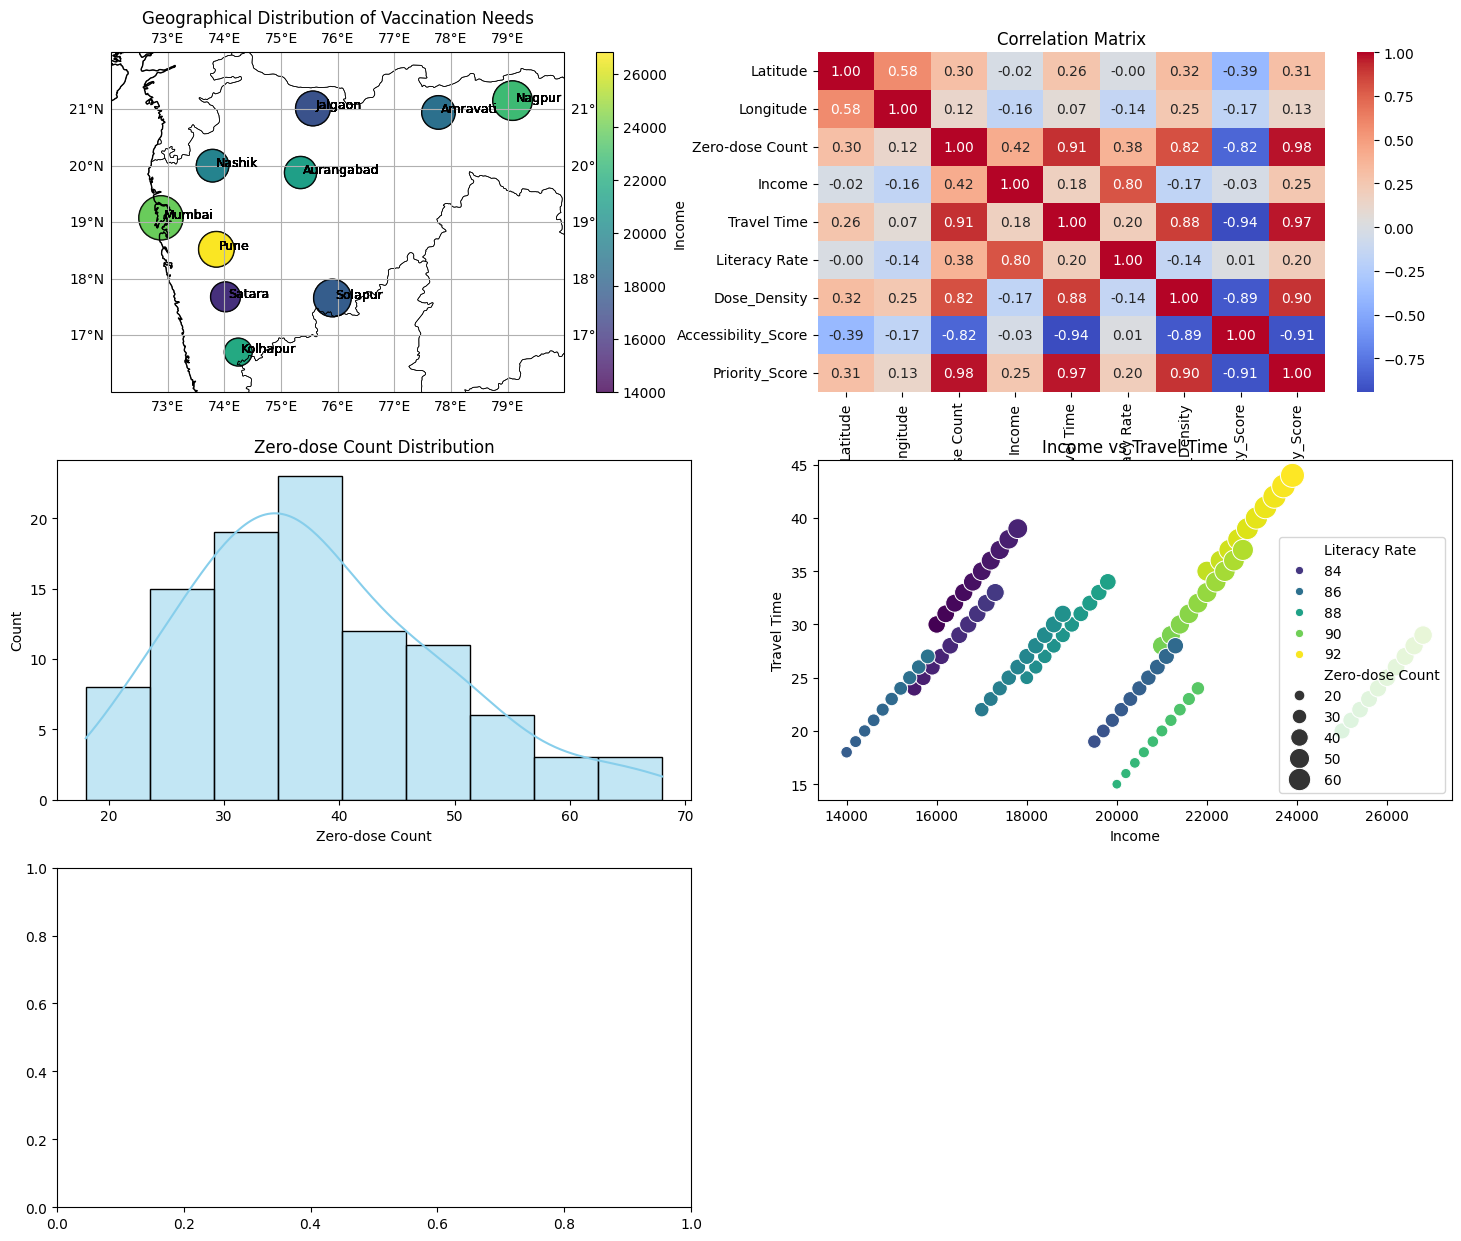

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import joblib
import warnings
warnings.filterwarnings('ignore')



df = pd.read_csv("E:/VaccineLedger/Backend/data/zero_dose_clusters_maharashtra.csv")

# Feature Engineering
df['Dose_Density'] = df['Zero-dose Count'] / (df['Income'] / 1000)  # Doses per income unit
df['Accessibility_Score'] = df['Literacy Rate'] / df['Travel Time']
df['Priority_Score'] = (df['Zero-dose Count'] * 0.4) + (df['Travel Time'] * 0.3) + ((100 - df['Literacy Rate']) * 0.3)

# EDA and Visualization
print("="*50)
print("Data Overview:")
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# Visualizations
plt.figure(figsize=(18, 15))

# Geographical Plot - Cartopy
ax = plt.subplot(3, 2, 1, projection=ccrs.PlateCarree())
ax.set_extent([72, 80, 16, 22])  # Focus on Maharashtra region
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Plot cities with size = zero-dose count, color = income
scatter = ax.scatter(df['Longitude'], df['Latitude'], 
                    s=df['Zero-dose Count']*15, 
                    c=df['Income'], 
                    cmap='viridis', 
                    alpha=0.8,
                    edgecolor='black',
                    transform=ccrs.PlateCarree())

# Add city labels
for i, row in df.iterrows():
    ax.text(row['Longitude'] + 0.05, row['Latitude'], row['City Name'], 
            fontsize=9, transform=ccrs.PlateCarree())

plt.colorbar(scatter, ax=ax, label='Income')
ax.set_title('Geographical Distribution of Vaccination Needs')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Correlation Heatmap
plt.subplot(3, 2, 2)
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

# Distribution Plots
plt.subplot(3, 2, 3)
sns.histplot(df['Zero-dose Count'], kde=True, color='skyblue')
plt.title('Zero-dose Count Distribution')

plt.subplot(3, 2, 4)
sns.scatterplot(x='Income', y='Travel Time', size='Zero-dose Count', 
                hue='Literacy Rate', data=df, palette='viridis', sizes=(50, 300))
plt.title('Income vs Travel Time')

# Box Plots
plt.subplot(3, 2, 5)
sns.boxplot(data=df[['Income', 'Travel Time', 'Literacy Rate']].apply(StandardScaler().fit_transform))
plt.title('Scaled Feature Distributions')

# Pair Plot
plt.subplot(3, 2, 6)
sns.pairplot(df[['Zero-dose Count', 'Income', 'Travel Time', 'Literacy Rate']])
plt.suptitle('Feature Relationships', y=1.02)
plt.tight_layout()
plt.savefig('vaccination_eda.png', dpi=300)
plt.show()

# Preprocessing
features = ['Latitude', 'Longitude', 'Zero-dose Count', 'Income', 'Travel Time', 'Literacy Rate',
            'Dose_Density', 'Accessibility_Score', 'Priority_Score']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering with KMeans - Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 6)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow and Silhouette
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Optimization')
plt.savefig('kmeans_optimization.png')
plt.show()

# Train KMeans with optimal k
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['KMeans_Cluster'] = kmeans_labels

# Train DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=2)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['DBSCAN_Cluster'] = dbscan_labels

# Model Evaluation
def evaluate_clustering(X, labels):
    if len(np.unique(labels)) < 2:
        return {
            'Silhouette': np.nan,
            'Calinski-Harabasz': np.nan,
            'Davies-Bouldin': np.nan
        }
    return {
        'Silhouette': silhouette_score(X, labels),
        'Calinski-Harabasz': calinski_harabasz_score(X, labels),
        'Davies-Bouldin': davies_bouldin_score(X, labels)
    }

kmeans_metrics = evaluate_clustering(X_scaled, kmeans_labels)
dbscan_metrics = evaluate_clustering(X_scaled, dbscan_labels)

print("\n" + "="*50)
print("Clustering Performance Metrics:")
print("\nKMeans Metrics:")
for metric, value in kmeans_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nDBSCAN Metrics:")
for metric, value in dbscan_metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualization of Clusters
plt.figure(figsize=(18, 8))

# Geographical Clusters - Cartopy
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([72, 80, 16, 22])  # Focus on Maharashtra region
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.STATES, linewidth=0.5)

# Plot clusters with different markers
markers = ['o', 's', '^', 'D', 'v']  # Different markers for clusters
for cluster in sorted(df['KMeans_Cluster'].unique()):
    cluster_df = df[df['KMeans_Cluster'] == cluster]
    ax1.scatter(cluster_df['Longitude'], cluster_df['Latitude'], 
               s=cluster_df['Zero-dose Count']*15, 
               marker=markers[cluster],
               label=f'Cluster {cluster}',
               alpha=0.8,
               edgecolor='black',
               transform=ccrs.PlateCarree())

# Add city labels
for i, row in df.iterrows():
    ax1.text(row['Longitude'] + 0.05, row['Latitude'], row['City Name'], 
            fontsize=9, transform=ccrs.PlateCarree())

ax1.legend(title='KMeans Clusters')
ax1.set_title('KMeans Geographical Clusters')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# t-SNE Visualization
plt.subplot(1, 2, 2)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['KMeans_Cluster'], 
                palette='viridis', s=150, style=df['DBSCAN_Cluster'], 
                markers=['o', 's', 'D', '^'])
plt.title('Cluster Comparison (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='KMeans (shape=DBSCAN)')
plt.tight_layout()
plt.savefig('cluster_results.png', dpi=300)
plt.show()

# Cluster Analysis
cluster_summary = df.groupby('KMeans_Cluster').agg({
    'Zero-dose Count': 'mean',
    'Income': 'mean',
    'Travel Time': 'mean',
    'Literacy Rate': 'mean',
    'Priority_Score': 'mean',
    'City Name': lambda x: ', '.join(x)
}).reset_index()

print("\n" + "="*50)
print("Cluster Summary:")
print(cluster_summary.to_string(index=False))

# Save models and scaler
joblib.dump(kmeans, 'vaccination_cluster_kmeans.pkl')
joblib.dump(scaler, 'vaccination_scaler.pkl')
print("\nModels saved successfully!")

# Prediction function
def predict_cluster(input_data):
    """Predict cluster for new city data"""
    try:
        # Create DataFrame from input
        input_df = pd.DataFrame([input_data])
        
        # Feature engineering
        input_df['Dose_Density'] = input_df['Zero-dose Count'] / (input_df['Income'] / 1000)
        input_df['Accessibility_Score'] = input_df['Literacy Rate'] / input_df['Travel Time']
        input_df['Priority_Score'] = (input_df['Zero-dose Count'] * 0.4) + \
                                     (input_df['Travel Time'] * 0.3) + \
                                     ((100 - input_df['Literacy Rate']) * 0.3)
        
        # Scale features
        scaler = joblib.load('vaccination_scaler.pkl')
        features = ['Latitude', 'Longitude', 'Zero-dose Count', 'Income', 
                   'Travel Time', 'Literacy Rate', 'Dose_Density', 
                   'Accessibility_Score', 'Priority_Score']
        processed_input = scaler.transform(input_df[features])
        
        # Predict cluster
        model = joblib.load('vaccination_cluster_kmeans.pkl')
        cluster = model.predict(processed_input)[0]
        
        # Get cluster characteristics
        cluster_profile = cluster_summary[cluster_summary['KMeans_Cluster'] == cluster].iloc[0]
        
        return {
            'cluster': int(cluster),
            'characteristics': {
                'avg_zero_dose': round(cluster_profile['Zero-dose Count'], 1),
                'avg_income': round(cluster_profile['Income'], 1),
                'avg_travel_time': round(cluster_profile['Travel Time'], 1),
                'avg_literacy': round(cluster_profile['Literacy Rate'], 1),
                'priority_score': round(cluster_profile['Priority_Score'], 1),
                'similar_cities': cluster_profile['City Name']
            }
        }
    except Exception as e:
        return {'error': str(e)}

# Example usage
sample_input = {
    'Area ID': 'MH010',
    'City Name': 'Thane',
    'District Name': 'Thane',
    'Latitude': 19.2183,
    'Longitude': 72.9781,
    'Zero-dose Count': 38,
    'Income': 23000,
    'Travel Time': 25,
    'Literacy Rate': 88.2
}

print("\n" + "="*50)
print("Sample Prediction:")
import pprint
pprint.pprint(predict_cluster(sample_input))

In [5]:
pip install cartopy


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 1.4 MB/s eta 0:00:08
   - -------------------------------------- 0.5/11.0 MB 1.4 MB/s eta 0:00:08
   ---- ----------------------------------- 1.3/11.0 MB 1.6 MB/s eta 0:00:06
   ----- ---------------------------------- 1.6/11.0 MB 1.6 MB/s eta 0:00:06
   ------ --------------------------------- 1.8/11.0 MB 1.5 MB/s eta 0:00:07
   ------ --------------------------------- 1.8/11.0 MB 1.5 MB/s eta 0:00:07
   ------- -------------------------------- 2.1/11.0 MB 1.3 MB/s eta 0:00:07
   -------- ------------------------------- 2.4/11.0 MB 1.3 MB/s eta 0:00:07
   ---------- ----------------------------- 2.9/11.0 MB 1.5 MB/s eta 0:00:06
   ----------- ---------------------------- 3.1/11.0 MB 1.5 MB/s eta 0:00:06
   ------------ --------------------------- 3.4/11.0 MB 1.4 MB/s eta 0:00:06
   ----------


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Data Overview:
Dataset Shape: (100, 12)

First 5 rows:
  Area ID City Name District Name  Latitude  Longitude  Zero-dose Count  \
0   MH001      Pune          Pune   18.5204    73.8567               35   
1   MH002    Mumbai        Mumbai   19.0760    72.8777               50   
2   MH003    Nashik        Nashik   19.9975    73.7898               28   
3   MH004   Solapur       Solapur   17.6599    75.9064               40   
4   MH005    Satara        Satara   17.6805    74.0183               22   

   Income  Travel Time  Literacy Rate  Dose_Density  Accessibility_Score  \
0   25000           20           89.6      1.400000             4.480000   
1   22000           35           91.2      2.272727             2.605714   
2   18000           25           87.1      1.555556             3.484000   
3   16000           30           82.5      2.500000             2.750000   
4   14000           18           85.3      1.571429             4.738889   

   Priority_Score  
0           23.12

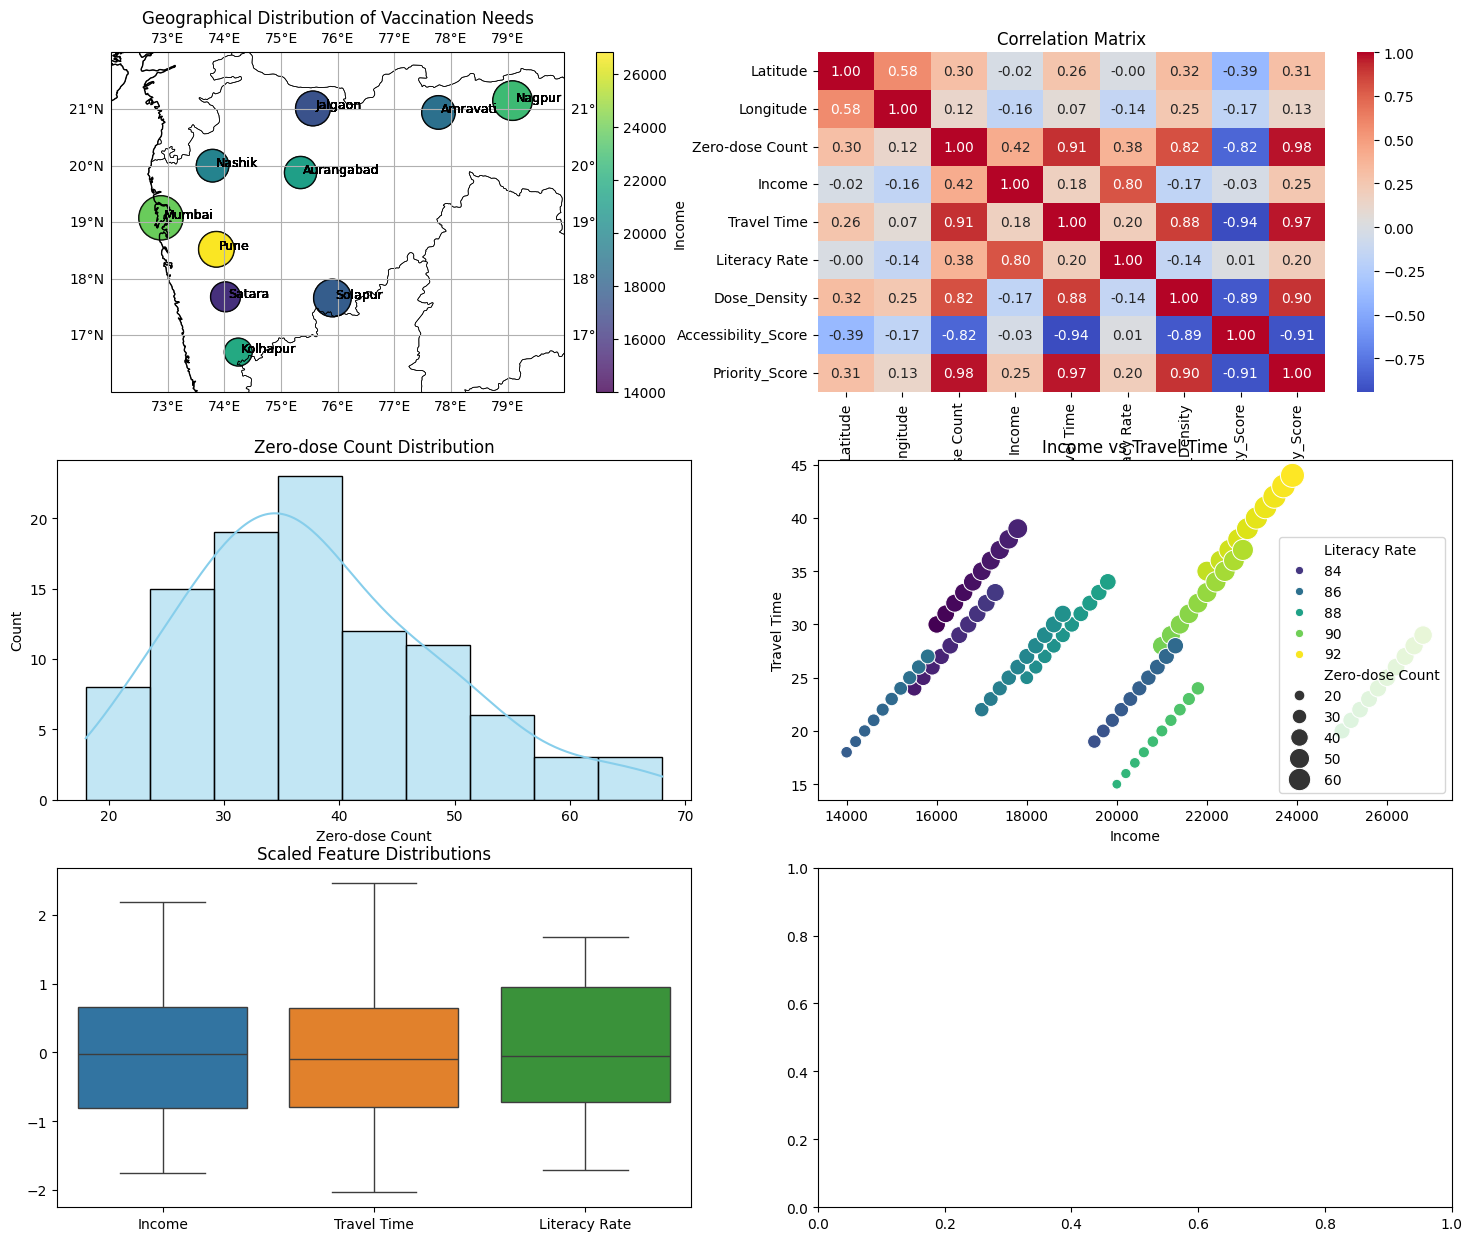

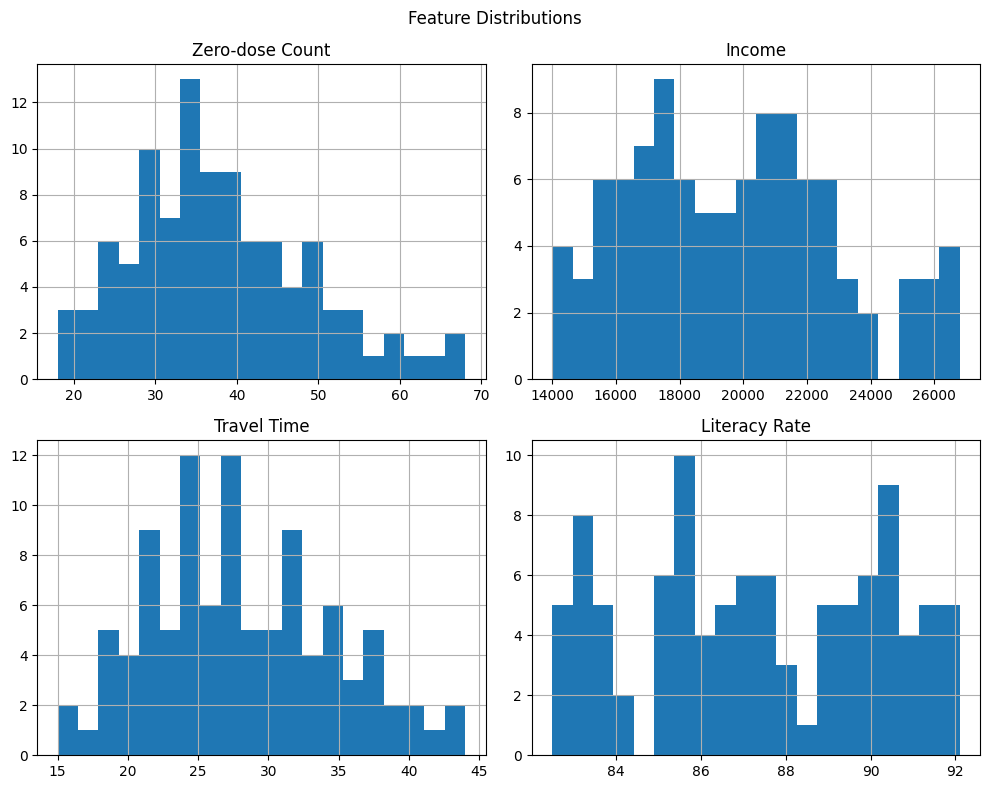

<Figure size 1200x1000 with 0 Axes>

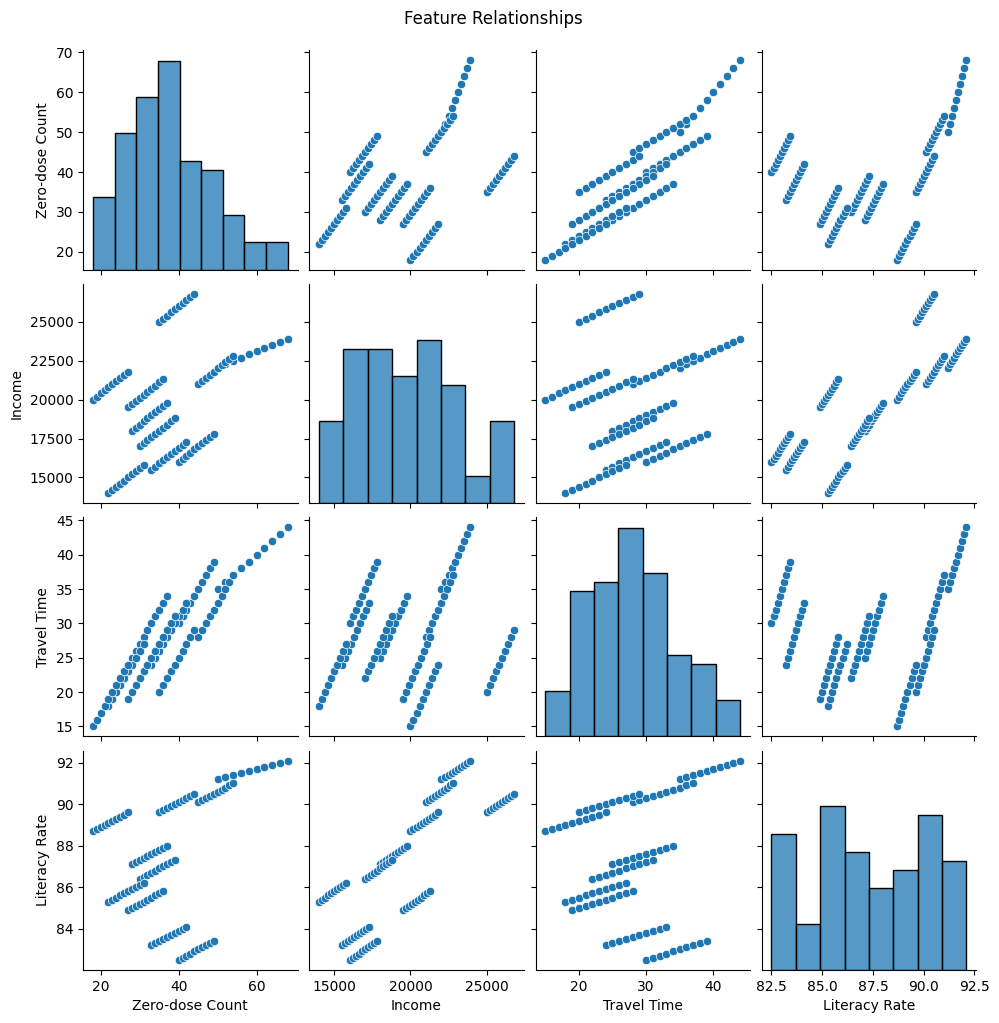

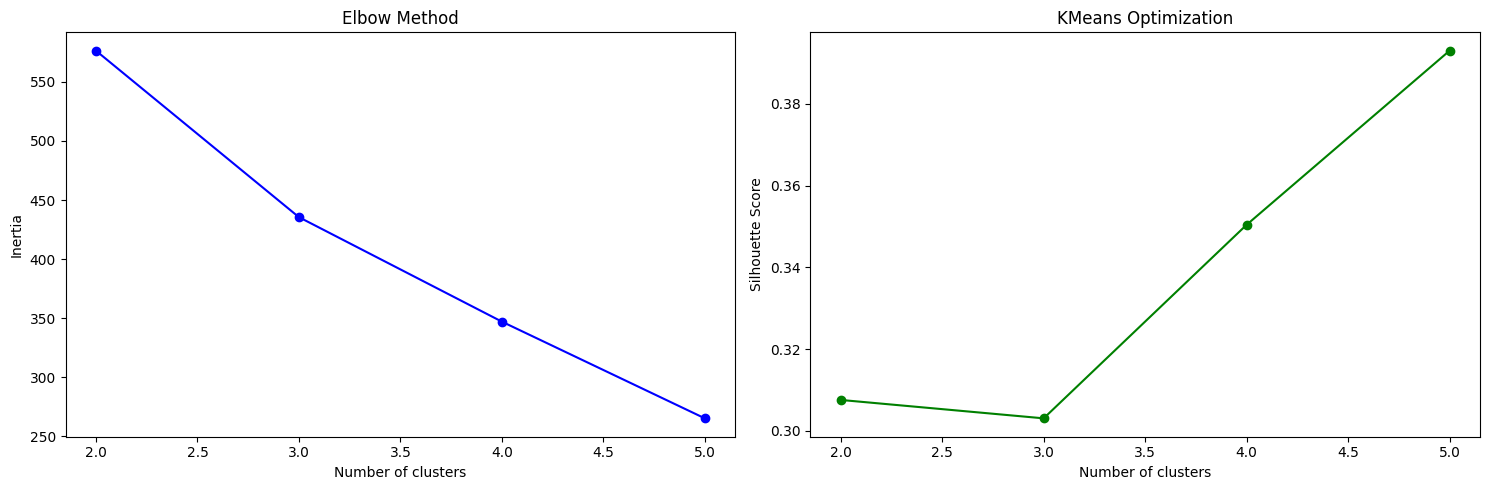


Clustering Performance Metrics:

KMeans Metrics:
Silhouette: 0.3031
Calinski-Harabasz: 51.7305
Davies-Bouldin: 1.2265

DBSCAN Metrics:
Silhouette: 0.5583
Calinski-Harabasz: 100.5876
Davies-Bouldin: 0.6629


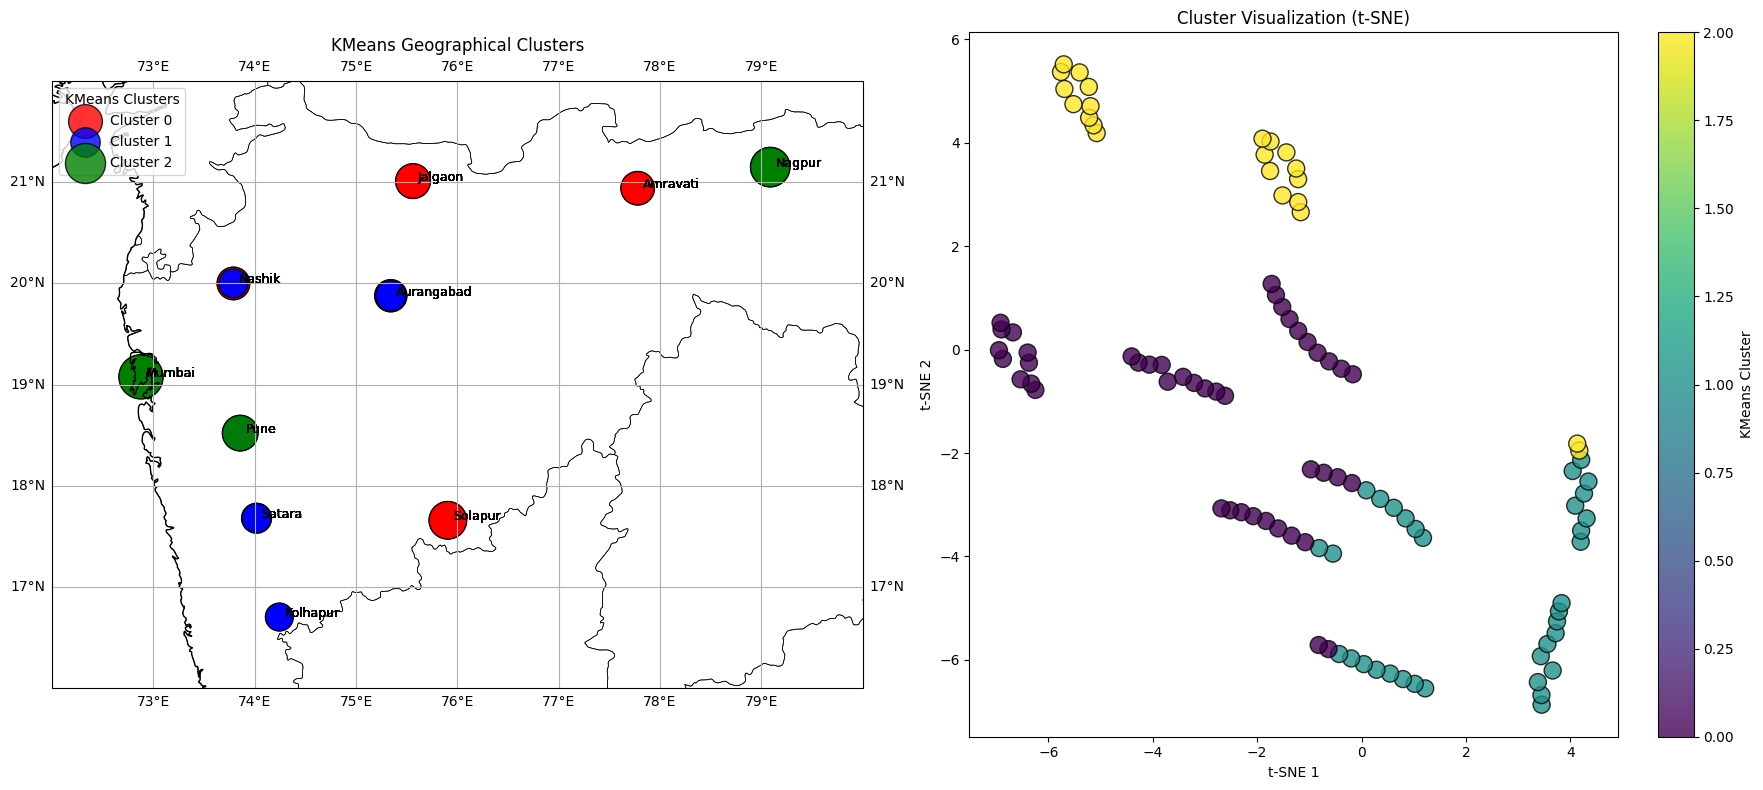


Cluster Summary:
 KMeans_Cluster  Zero-dose Count       Income  Travel Time  Literacy Rate  Priority_Score                                                                                                                                                                                                                                                                                                                                                                                                              City Name
              0        37.090909 17731.818182    29.500000      85.240909       28.114091 Solapur, Amravati, Jalgaon, Solapur, Amravati, Jalgaon, Nashik, Solapur, Amravati, Jalgaon, Nashik, Solapur, Amravati, Jalgaon, Nashik, Solapur, Amravati, Jalgaon, Nashik, Solapur, Amravati, Jalgaon, Nashik, Solapur, Amravati, Aurangabad, Jalgaon, Nashik, Solapur, Amravati, Aurangabad, Jalgaon, Nashik, Solapur, Satara, Amravati, Aurangabad, Jalgaon, Nashik, Solapur, Satara, Amravati, Aurangab

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import joblib
import warnings
import os
warnings.filterwarnings('ignore')

# Create cluster_model directory if it doesn't exist
os.makedirs('cluster_model', exist_ok=True)

# Load data
df = pd.read_csv("E:/VaccineLedger/Backend/data/zero_dose_clusters_maharashtra.csv")

# Feature Engineering
df['Dose_Density'] = df['Zero-dose Count'] / (df['Income'] / 1000)  # Doses per income unit
df['Accessibility_Score'] = df['Literacy Rate'] / df['Travel Time']
df['Priority_Score'] = (df['Zero-dose Count'] * 0.4) + (df['Travel Time'] * 0.3) + ((100 - df['Literacy Rate']) * 0.3)

# EDA and Visualization
print("="*50)
print("Data Overview:")
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# Visualizations
plt.figure(figsize=(18, 15))

# Geographical Plot - Cartopy
ax = plt.subplot(3, 2, 1, projection=ccrs.PlateCarree())
ax.set_extent([72, 80, 16, 22])  # Focus on Maharashtra region
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Plot cities with size = zero-dose count, color = income
scatter = ax.scatter(df['Longitude'], df['Latitude'], 
                    s=df['Zero-dose Count']*15, 
                    c=df['Income'], 
                    cmap='viridis', 
                    alpha=0.8,
                    edgecolor='black',
                    transform=ccrs.PlateCarree())

# Add city labels
for i, row in df.iterrows():
    ax.text(row['Longitude'] + 0.05, row['Latitude'], row['City Name'], 
            fontsize=9, transform=ccrs.PlateCarree())

plt.colorbar(scatter, ax=ax, label='Income')
ax.set_title('Geographical Distribution of Vaccination Needs')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Correlation Heatmap
plt.subplot(3, 2, 2)
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

# Distribution Plots
plt.subplot(3, 2, 3)
sns.histplot(df['Zero-dose Count'], kde=True, color='skyblue')
plt.title('Zero-dose Count Distribution')

plt.subplot(3, 2, 4)
sns.scatterplot(x='Income', y='Travel Time', size='Zero-dose Count', 
                hue='Literacy Rate', data=df, palette='viridis', sizes=(50, 300))
plt.title('Income vs Travel Time')

# Box Plots - Fixed version
plt.subplot(3, 2, 5)
# Create scaled data for boxplot
features_for_boxplot = ['Income', 'Travel Time', 'Literacy Rate']
scaled_data = StandardScaler().fit_transform(df[features_for_boxplot])
scaled_df = pd.DataFrame(scaled_data, columns=features_for_boxplot)
sns.boxplot(data=scaled_df)
plt.title('Scaled Feature Distributions')

# Feature distribution plot instead of pair plot (which would be too complex for subplot)
plt.subplot(3, 2, 6)
# Create a simple distribution plot
df[['Zero-dose Count', 'Income', 'Travel Time', 'Literacy Rate']].hist(bins=20, figsize=(10, 8))
plt.suptitle('Feature Distributions')

plt.tight_layout()
plt.savefig('vaccination_eda.png', dpi=300, bbox_inches='tight')
plt.show()

# Create separate pair plot
plt.figure(figsize=(12, 10))
sns.pairplot(df[['Zero-dose Count', 'Income', 'Travel Time', 'Literacy Rate']])
plt.suptitle('Feature Relationships', y=1.02)
plt.savefig('feature_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

# Preprocessing
features = ['Latitude', 'Longitude', 'Zero-dose Count', 'Income', 'Travel Time', 'Literacy Rate',
            'Dose_Density', 'Accessibility_Score', 'Priority_Score']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering with KMeans - Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 6)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow and Silhouette
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Optimization')
plt.tight_layout()
plt.savefig('kmeans_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Train KMeans with optimal k
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['KMeans_Cluster'] = kmeans_labels

# Train DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=2)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['DBSCAN_Cluster'] = dbscan_labels

# Model Evaluation
def evaluate_clustering(X, labels):
    if len(np.unique(labels)) < 2:
        return {
            'Silhouette': np.nan,
            'Calinski-Harabasz': np.nan,
            'Davies-Bouldin': np.nan
        }
    return {
        'Silhouette': silhouette_score(X, labels),
        'Calinski-Harabasz': calinski_harabasz_score(X, labels),
        'Davies-Bouldin': davies_bouldin_score(X, labels)
    }

kmeans_metrics = evaluate_clustering(X_scaled, kmeans_labels)
dbscan_metrics = evaluate_clustering(X_scaled, dbscan_labels)

print("\n" + "="*50)
print("Clustering Performance Metrics:")
print("\nKMeans Metrics:")
for metric, value in kmeans_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nDBSCAN Metrics:")
for metric, value in dbscan_metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualization of Clusters
plt.figure(figsize=(18, 8))

# Geographical Clusters - Cartopy
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([72, 80, 16, 22])  # Focus on Maharashtra region
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.STATES, linewidth=0.5)

# Plot clusters with different colors
colors = ['red', 'blue', 'green', 'orange', 'purple']
for cluster in sorted(df['KMeans_Cluster'].unique()):
    cluster_df = df[df['KMeans_Cluster'] == cluster]
    ax1.scatter(cluster_df['Longitude'], cluster_df['Latitude'], 
               s=cluster_df['Zero-dose Count']*15, 
               c=colors[cluster],
               label=f'Cluster {cluster}',
               alpha=0.8,
               edgecolor='black',
               transform=ccrs.PlateCarree())

# Add city labels
for i, row in df.iterrows():
    ax1.text(row['Longitude'] + 0.05, row['Latitude'], row['City Name'], 
            fontsize=9, transform=ccrs.PlateCarree())

ax1.legend(title='KMeans Clusters')
ax1.set_title('KMeans Geographical Clusters')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# t-SNE Visualization
plt.subplot(1, 2, 2)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create scatter plot for t-SNE
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['KMeans_Cluster'], 
                     cmap='viridis', s=150, alpha=0.8, edgecolor='black')
plt.colorbar(scatter, label='KMeans Cluster')
plt.title('Cluster Visualization (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.savefig('cluster_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Cluster Analysis
cluster_summary = df.groupby('KMeans_Cluster').agg({
    'Zero-dose Count': 'mean',
    'Income': 'mean',
    'Travel Time': 'mean',
    'Literacy Rate': 'mean',
    'Priority_Score': 'mean',
    'City Name': lambda x: ', '.join(x)
}).reset_index()

print("\n" + "="*50)
print("Cluster Summary:")
print(cluster_summary.to_string(index=False))

# Save models and scaler to cluster_model folder
joblib.dump(kmeans, 'cluster_model/vaccination_cluster_kmeans.pkl')
joblib.dump(scaler, 'cluster_model/vaccination_scaler.pkl')
joblib.dump(cluster_summary, 'cluster_model/cluster_summary.pkl')
print("\nModels saved successfully to cluster_model folder!")

# Prediction function
def predict_cluster(input_data):
    """Predict cluster for new city data"""
    try:
        # Create DataFrame from input
        input_df = pd.DataFrame([input_data])
        
        # Feature engineering
        input_df['Dose_Density'] = input_df['Zero-dose Count'] / (input_df['Income'] / 1000)
        input_df['Accessibility_Score'] = input_df['Literacy Rate'] / input_df['Travel Time']
        input_df['Priority_Score'] = (input_df['Zero-dose Count'] * 0.4) + \
                                     (input_df['Travel Time'] * 0.3) + \
                                     ((100 - input_df['Literacy Rate']) * 0.3)
        
        # Scale features
        scaler = joblib.load('cluster_model/vaccination_scaler.pkl')
        features = ['Latitude', 'Longitude', 'Zero-dose Count', 'Income', 
                   'Travel Time', 'Literacy Rate', 'Dose_Density', 
                   'Accessibility_Score', 'Priority_Score']
        processed_input = scaler.transform(input_df[features])
        
        # Predict cluster
        model = joblib.load('cluster_model/vaccination_cluster_kmeans.pkl')
        cluster = model.predict(processed_input)[0]
        
        # Get cluster characteristics
        cluster_summary = joblib.load('cluster_model/cluster_summary.pkl')
        cluster_profile = cluster_summary[cluster_summary['KMeans_Cluster'] == cluster].iloc[0]
        
        return {
            'cluster': int(cluster),
            'characteristics': {
                'avg_zero_dose': round(cluster_profile['Zero-dose Count'], 1),
                'avg_income': round(cluster_profile['Income'], 1),
                'avg_travel_time': round(cluster_profile['Travel Time'], 1),
                'avg_literacy': round(cluster_profile['Literacy Rate'], 1),
                'priority_score': round(cluster_profile['Priority_Score'], 1),
                'similar_cities': cluster_profile['City Name']
            }
        }
    except Exception as e:
        return {'error': str(e)}

# Example usage
sample_input = {
    'Area ID': 'MH010',
    'City Name': 'Thane',
    'District Name': 'Thane',
    'Latitude': 19.2183,
    'Longitude': 72.9781,
    'Zero-dose Count': 38,
    'Income': 23000,
    'Travel Time': 25,
    'Literacy Rate': 88.2
}

print("\n" + "="*50)
print("Sample Prediction:")
import pprint
pprint.pprint(predict_cluster(sample_input))

# Additional utility function to load and use saved model
def load_model_and_predict(input_data):
    """Load saved model and make prediction"""
    try:
        # Load saved components
        kmeans = joblib.load('cluster_model/vaccination_cluster_kmeans.pkl')
        scaler = joblib.load('cluster_model/vaccination_scaler.pkl')
        cluster_summary = joblib.load('cluster_model/cluster_summary.pkl')
        
        # Process input
        input_df = pd.DataFrame([input_data])
        input_df['Dose_Density'] = input_df['Zero-dose Count'] / (input_df['Income'] / 1000)
        input_df['Accessibility_Score'] = input_df['Literacy Rate'] / input_df['Travel Time']
        input_df['Priority_Score'] = (input_df['Zero-dose Count'] * 0.4) + \
                                     (input_df['Travel Time'] * 0.3) + \
                                     ((100 - input_df['Literacy Rate']) * 0.3)
        
        features = ['Latitude', 'Longitude', 'Zero-dose Count', 'Income', 
                   'Travel Time', 'Literacy Rate', 'Dose_Density', 
                   'Accessibility_Score', 'Priority_Score']
        processed_input = scaler.transform(input_df[features])
        
        # Make prediction
        cluster = kmeans.predict(processed_input)[0]
        
        return {
            'success': True,
            'cluster': int(cluster),
            'model_loaded': True
        }
    except Exception as e:
        return {
            'success': False,
            'error': str(e)
        }

print("\n" + "="*50)
print("Model Loading Test:")
test_result = load_model_and_predict(sample_input)
print(f"Model loading test result: {test_result}")

print("\n" + "="*50)
print("Files saved in cluster_model folder:")
for file in os.listdir('cluster_model'):
    print(f"- {file}")